In [1]:
import os
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import copy
import argparse

In [2]:
current_dir = os.getcwd()
current_dir

'/home/ajivani/WLROM_new/HeatEquation'

In [3]:
%matplotlib inline

In [4]:
import time

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--debug', action='store_true')
parser.add_argument('-runCNN', type=eval, default=True, choices=[True, False])


args = parser.parse_args(args=())
args

Namespace(tol=0.001, adjoint=True, lr=0.1, debug=False, runCNN=True)

In [7]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

### Setup train and test data for 2D toy example

We will write trainloaders that will output x as initial condition and y as the predictions for next k timesteps!

In [10]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [11]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, 
                 bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, 
            stride=stride, 
            padding=padding, 
            dilation=dilation, 
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

In [12]:
def norm(dim):
    if dim == 1:
        return nn.GroupNorm(dim, dim)
    else:
        return nn.GroupNorm(min(8, dim), dim)

In [13]:
import pickle

# Read (Load) the data from the pickle file
with open("2d_pilot_data_cdr.pkl", 'rb') as f:
    y_orig = pickle.load(f)
    
y_orig = np.array(y_orig)
# y_orig = np.transpose(y_orig, (1, 2, 0))
y_orig.max(), y_orig.min()

(0.08621255409430216, -0.08111475107997271)

In [14]:
y_orig.shape

(615, 64, 64)

In [15]:
# plt.imshow(y_orig[0, :, :],
#           origin="lower")
# plt.colorbar()

In [16]:
# plt.imshow(y_orig[614, :, :],
#           origin="lower")
# plt.colorbar()

In [17]:
y_scaled = (y_orig - y_orig.min())/(y_orig.max() - y_orig.min())

(array([  11460.,   22001.,   41813.,  109500., 1845346.,  348413.,
          78197.,   34269.,   18463.,    9578.]),
 array([-0.08111475, -0.06438202, -0.04764929, -0.03091656, -0.01418383,
         0.0025489 ,  0.01928163,  0.03601436,  0.05274709,  0.06947982,
         0.08621255]),
 <BarContainer object of 10 artists>)

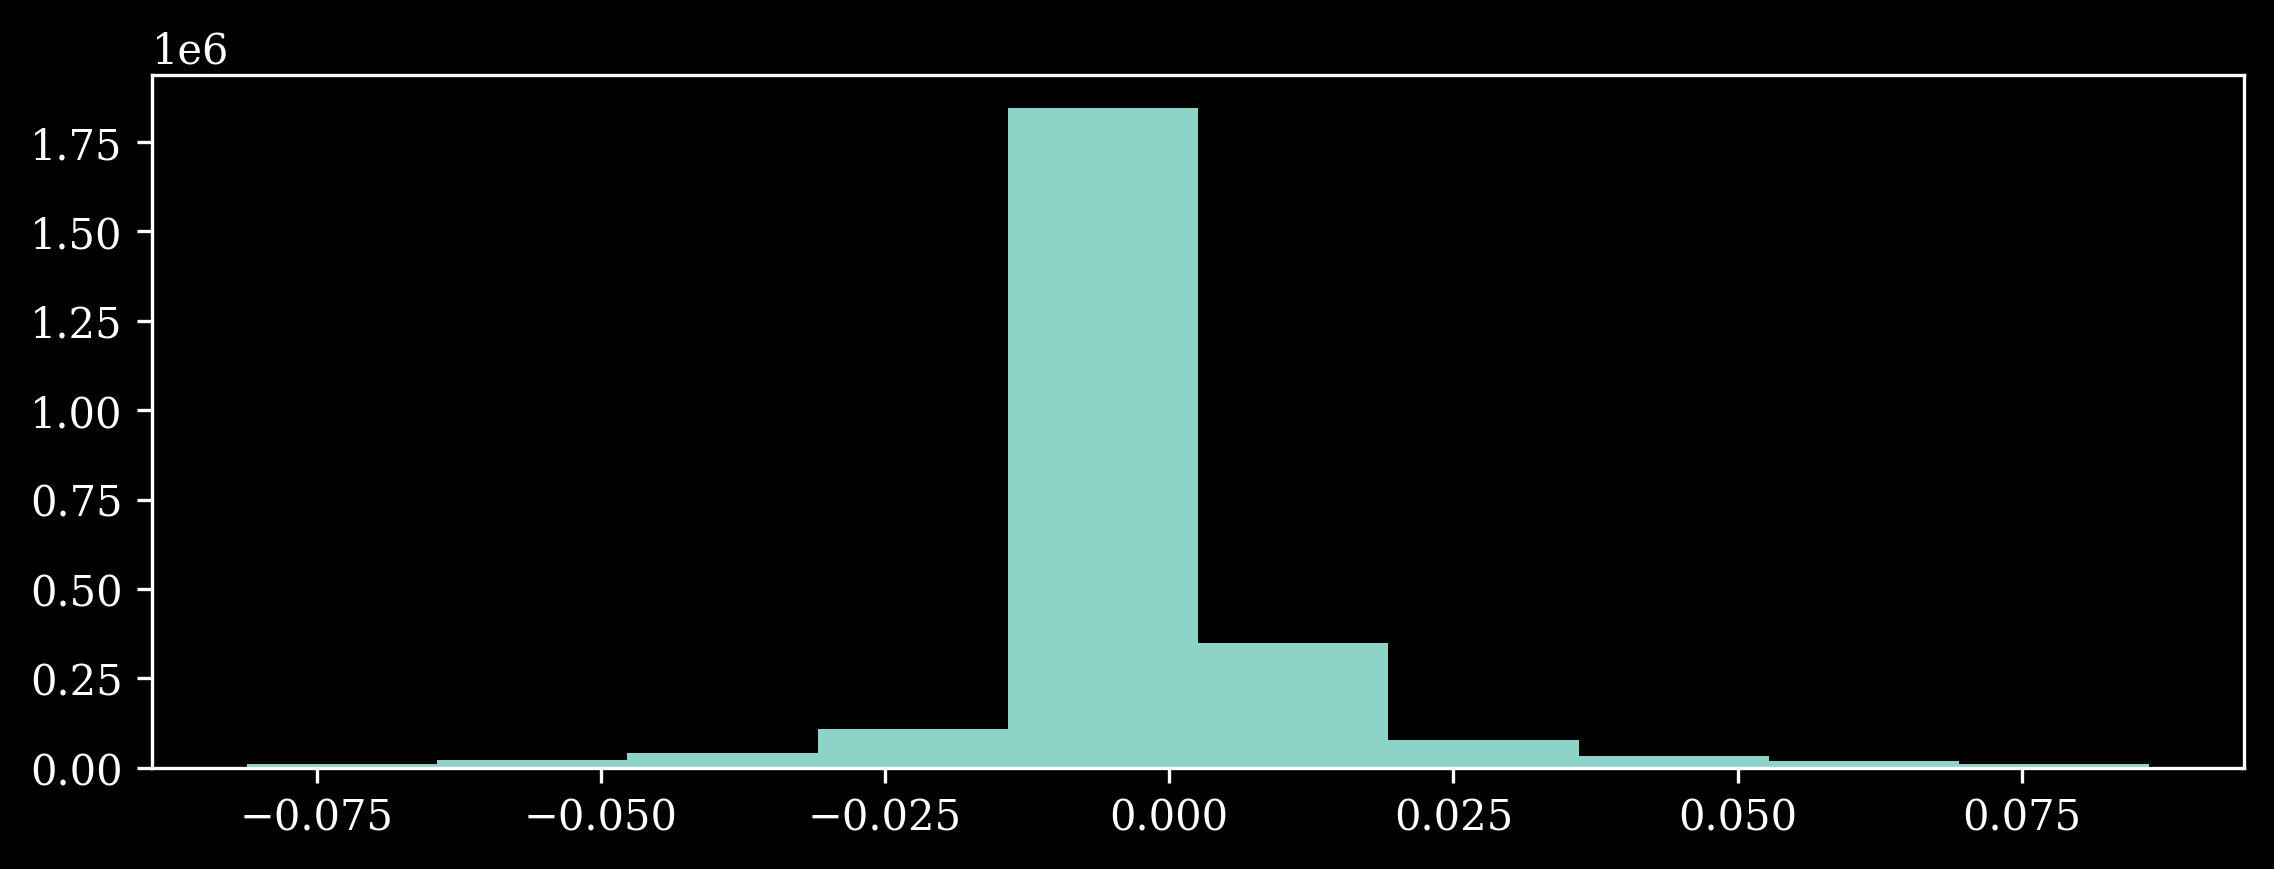

In [18]:
plt.hist(y_orig.flatten())

(array([  11460.,   22001.,   41813.,  109500., 1845346.,  348413.,
          78197.,   34269.,   18463.,    9578.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

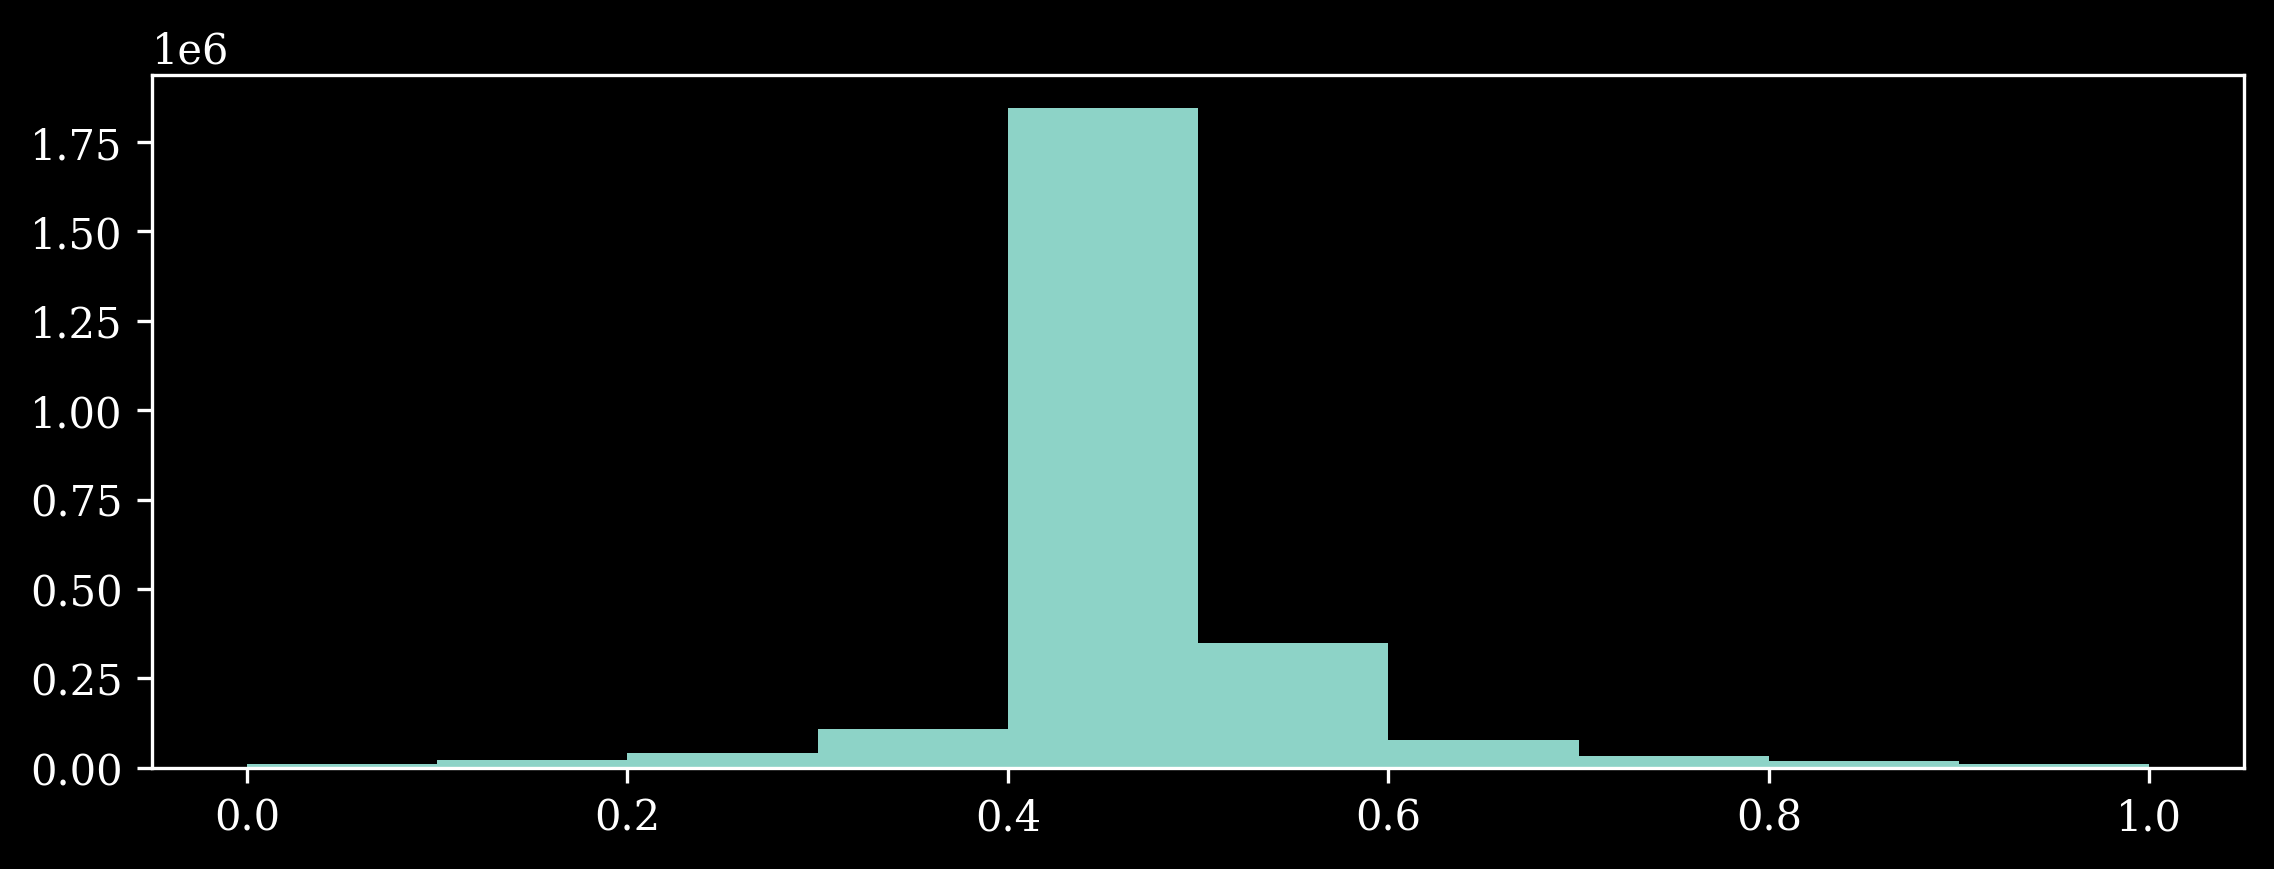

In [19]:
plt.hist(y_scaled.flatten())

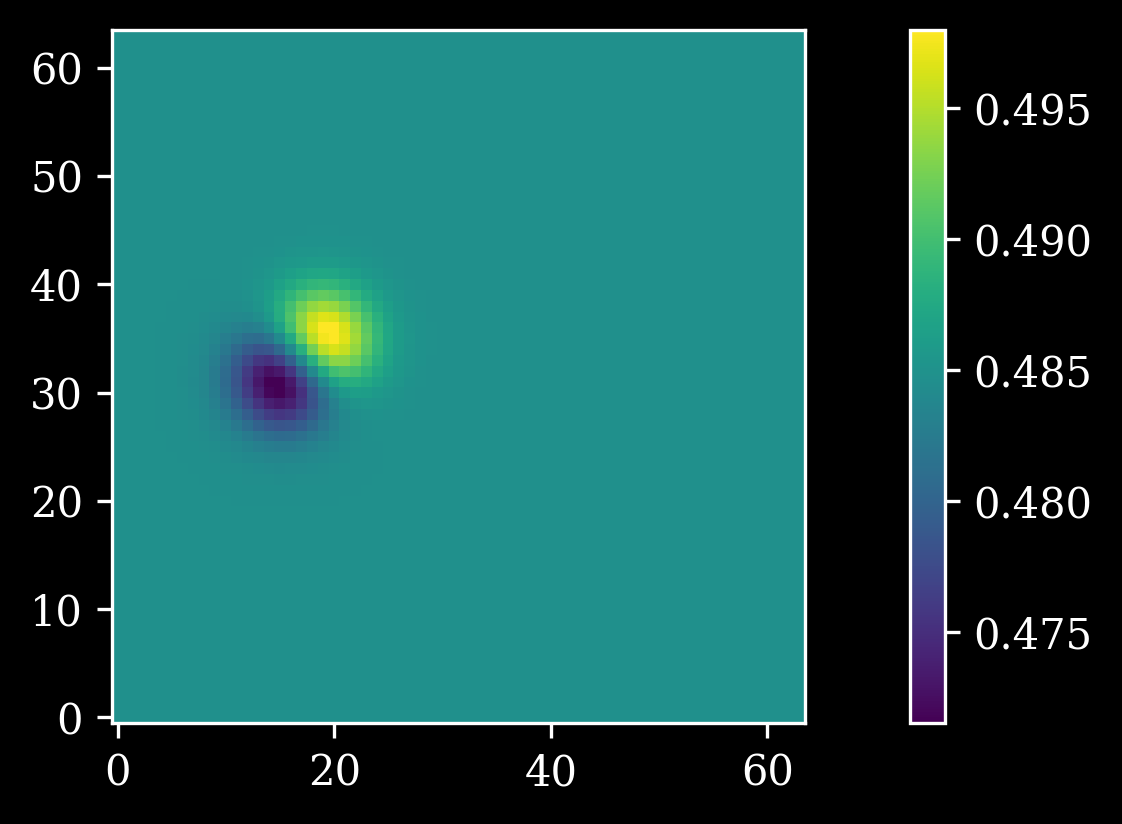

In [20]:
plt.imshow(y_scaled[0, :, :],
          origin="lower")
plt.colorbar()

In [21]:
y_orig_diff = np.diff(y_orig, axis=0)
y_orig_diff = np.transpose(y_orig_diff, (1, 2, 0))
y_orig_diff.shape

(64, 64, 614)

In [22]:
y_diff_flattened = y_orig_diff.reshape(-1, y_orig_diff.shape[-1])
y_diff_flattened.shape

(4096, 614)

In [23]:
# plt.imshow(y_diff_flattened[:, :100],
#            cmap="gray")
# plt.colorbar()

In [24]:
y_orig.shape

(615, 64, 64)

In [25]:
import toy_utils as ut

In [26]:
nxHF = 64
nyHF = 64

uHFFinal, vHFFinal = ut.getVelocitiesGeneric(nxHF, nyHF)

In [27]:
x, y, xm, ym, XM, YM, dx, dy, dxi, dyi, dxi2, dyi2 = ut.getGridQuantities(nxHF, nyHF)

alpha = 1e-2

CFL = 0.8

maxU = np.max(np.abs(uHFFinal))
maxU = np.max([maxU, np.max(np.abs(vHFFinal))])
dt_c = CFL * dx / maxU  # dt based on convective CFL
dt_v = CFL * dx ** 2 / alpha / 4  # dt based on viscous CFL


dt = min(dt_c, dt_v)   # Simulation timestep
dt

0.0048828125

In [28]:
tf = 3.0

all_times = np.arange(0, tf, dt)
all_times.shape

(615,)

In [29]:
t_train_torch = torch.tensor(np.float32(all_times)).to(device)
t_train_torch[:5]

tensor([0.0000, 0.0049, 0.0098, 0.0146, 0.0195], device='cuda:0')

In [30]:
# y_orig_torch_full = torch.from_numpy(np.expand_dims(np.float32(y_orig), axis=1)).to(device)
y_orig_torch_full = torch.from_numpy(np.expand_dims(np.float32(y_scaled), axis=1)).to(device)
y_orig_torch_full.shape

torch.Size([615, 1, 64, 64])

In [31]:
y_orig_torch_full[[0]].shape

torch.Size([1, 1, 64, 64])

In [32]:
# y0_orig = y_orig[0, :, :]
y0_orig = y_scaled[0, :, :]
y0_orig.shape

(64, 64)

In [33]:
y0_orig_torch = torch.from_numpy(np.expand_dims(np.float32(y0_orig), axis=(0, 1))).to(device)
y0_orig_torch.shape

torch.Size([1, 1, 64, 64])

In [34]:
data_size = t_train_torch.shape[0]
batch_time = 5
batch_size = 10

In [35]:
# VERIFIED THAT THIS WORKS PROPERLY
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    batch_y0 = torch_train_data[s]
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]
        
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [36]:
by0, bt, by = get_batch(y_orig_torch_full, t_train_torch, batch_time = batch_time, batch_size = batch_size)
by0.shape, bt.shape, by.shape

(torch.Size([10, 1, 64, 64]),
 torch.Size([10, 5]),
 torch.Size([5, 10, 1, 64, 64]))

In [37]:
bt

tensor([[1.0986, 1.1035, 1.1084, 1.1133, 1.1182],
        [2.4023, 2.4072, 2.4121, 2.4170, 2.4219],
        [1.9629, 1.9678, 1.9727, 1.9775, 1.9824],
        [1.9238, 1.9287, 1.9336, 1.9385, 1.9434],
        [0.5811, 0.5859, 0.5908, 0.5957, 0.6006],
        [0.5371, 0.5420, 0.5469, 0.5518, 0.5566],
        [0.8594, 0.8643, 0.8691, 0.8740, 0.8789],
        [1.5576, 1.5625, 1.5674, 1.5723, 1.5771],
        [0.3125, 0.3174, 0.3223, 0.3271, 0.3320],
        [1.0010, 1.0059, 1.0107, 1.0156, 1.0205]], device='cuda:0')

In [38]:
# data_gen = inf_generator(train_loader)

In [39]:
class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        #         self.relu = nn.ReLU(inplace=True)
        #         self.act = nn.Tanh()
        self.act = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 
                                  ksize=(3, 3),
                                  stride=(1, 1), 
                                  padding=(1, 1),
                                  dilation=(1, 1))
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 
                                  ksize=(3, 3), 
                                  stride=(1, 1),
                                  padding=(1, 1), 
                                  dilation=(1, 1))
        self.norm3 = norm(dim)
        #         self.nfe = 0

    def forward(self, t, x):
        #         self.nfe += 1
        out = self.norm1(x)
        #         out = self.relu(out)
        out = self.act(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.act(out)
        #         out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out

In [40]:
class ODEBlockCNN(nn.Module):
    """
    `dim` sets the dimension of the input channel that goes into the `conv` layers of `ODEfunc`. We keep it at 1
    `integration_time` is a 2D array of size `batch_size` x `batch_time` e.g 10x5. we want to take each row of the array and
    use that for `odeint` on every IC from our sequence.
    """
    def __init__(self, dim):
        super(ODEBlockCNN, self).__init__()
        
        self.dim = dim
        
        self.odefunc = ODEfunc(self.dim)
        
        self.downsampling = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)),
                            norm(16),
                            #                             nn.Tanh(),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(kernel_size=(3, 3),
                                         stride=(1, 1),
                                         padding=(1, 1),
                                         dilation=(1, 1)),             
                            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)),
                            norm(16),
                            nn.MaxPool2d(kernel_size=(3, 3),
                                         stride=(1, 1),
                                         padding=(1, 1),
                                         dilation=(1, 1)),
                            #                             nn.Tanh(),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3, 3), 
                                       stride=(1, 1),
                                       padding=(1, 1),
                                       dilation=(1, 1)))

    def forward(self, xt_list):
        x = xt_list[0]
        
        integration_time = xt_list[1].type_as(x)
        
        x = self.downsampling(x)
        
        if len(integration_time.shape) > 1:
            out = torch.cat([odeint(self.odefunc, x[[i]], integration_time[i, :], rtol=args.tol,
                                      atol=args.tol) for i in range(integration_time.shape[0])], dim=1)
        else:
            # print("Getting prediction for full series")
            out = odeint(self.odefunc, x, integration_time, rtol=args.tol,
                                      atol=args.tol)
            out = torch.squeeze(out, dim=1)

        
        return out

In [41]:
my_cnn_model = ODEBlockCNN(1).to(device)
optimizer = optim.Adam(my_cnn_model.parameters(), lr=1e-3)
end = time.time()

In [42]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.losses.append(self.avg)

In [43]:
niters = 1000
test_freq = 5

In [44]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

if args.runCNN:

    for itr in range(1, niters + 1):
        optimizer.zero_grad()

        batch_y0, batch_t, batch_y = get_batch(y_orig_torch_full, t_train_torch)

        pred_y = my_cnn_model([batch_y0, batch_t])

        loss = torch.mean(torch.abs(pred_y - batch_y))
        #         loss = torch.nn.functional.mse_loss(pred_y, batch_y)
        
        # REPLACE LOSS BY SOMETHING MORE ELABORATE
        #         loss = getAbsoluteAvgBatchLoss(pred_y, batch_y)
        
        loss.backward()
        optimizer.step()

        #     step_loss.append(loss.item())

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                pred_y_full_series = my_cnn_model([y_orig_torch_full[[0]], t_train_torch])
                loss_full_series = torch.mean(torch.abs(pred_y_full_series 
                                                        - y_orig_torch_full))
                
                # loss_full_series = torch.nn.functional.mse_loss(pred_y_full_series, y_orig_torch_full)
                #                 loss_full_series = getAbsoluteAvgBatchLoss(pred_y_full_series, x_orig_torch_full)
                print("Iter {:04d} | Total Loss {:.6f} ".format(itr,
                                                                loss_full_series.item(), 
                                                                ))
                # ii += 1

        end = time.time()

Iter 0005 | Total Loss 1.318288 
Iter 0010 | Total Loss 1.300765 
Iter 0015 | Total Loss 1.228861 
Iter 0020 | Total Loss 1.134027 
Iter 0025 | Total Loss 1.111182 
Iter 0030 | Total Loss 0.944330 
Iter 0035 | Total Loss 0.846897 
Iter 0040 | Total Loss 0.865917 
Iter 0045 | Total Loss 0.882967 
Iter 0050 | Total Loss 0.873750 
Iter 0055 | Total Loss 0.792029 
Iter 0060 | Total Loss 0.795102 
Iter 0065 | Total Loss 0.688563 
Iter 0070 | Total Loss 0.591871 
Iter 0075 | Total Loss 0.443091 
Iter 0080 | Total Loss 0.477264 
Iter 0085 | Total Loss 0.444892 
Iter 0090 | Total Loss 0.540936 
Iter 0095 | Total Loss 0.551079 
Iter 0100 | Total Loss 0.495149 
Iter 0105 | Total Loss 0.468066 
Iter 0110 | Total Loss 0.465764 
Iter 0115 | Total Loss 0.419460 
Iter 0120 | Total Loss 0.428426 
Iter 0125 | Total Loss 0.428943 
Iter 0130 | Total Loss 0.577148 
Iter 0135 | Total Loss 0.527488 
Iter 0140 | Total Loss 0.525561 
Iter 0145 | Total Loss 0.671908 
Iter 0150 | Total Loss 0.706673 
Iter 0155 

Text(0, 0.5, 'Running Average Loss')

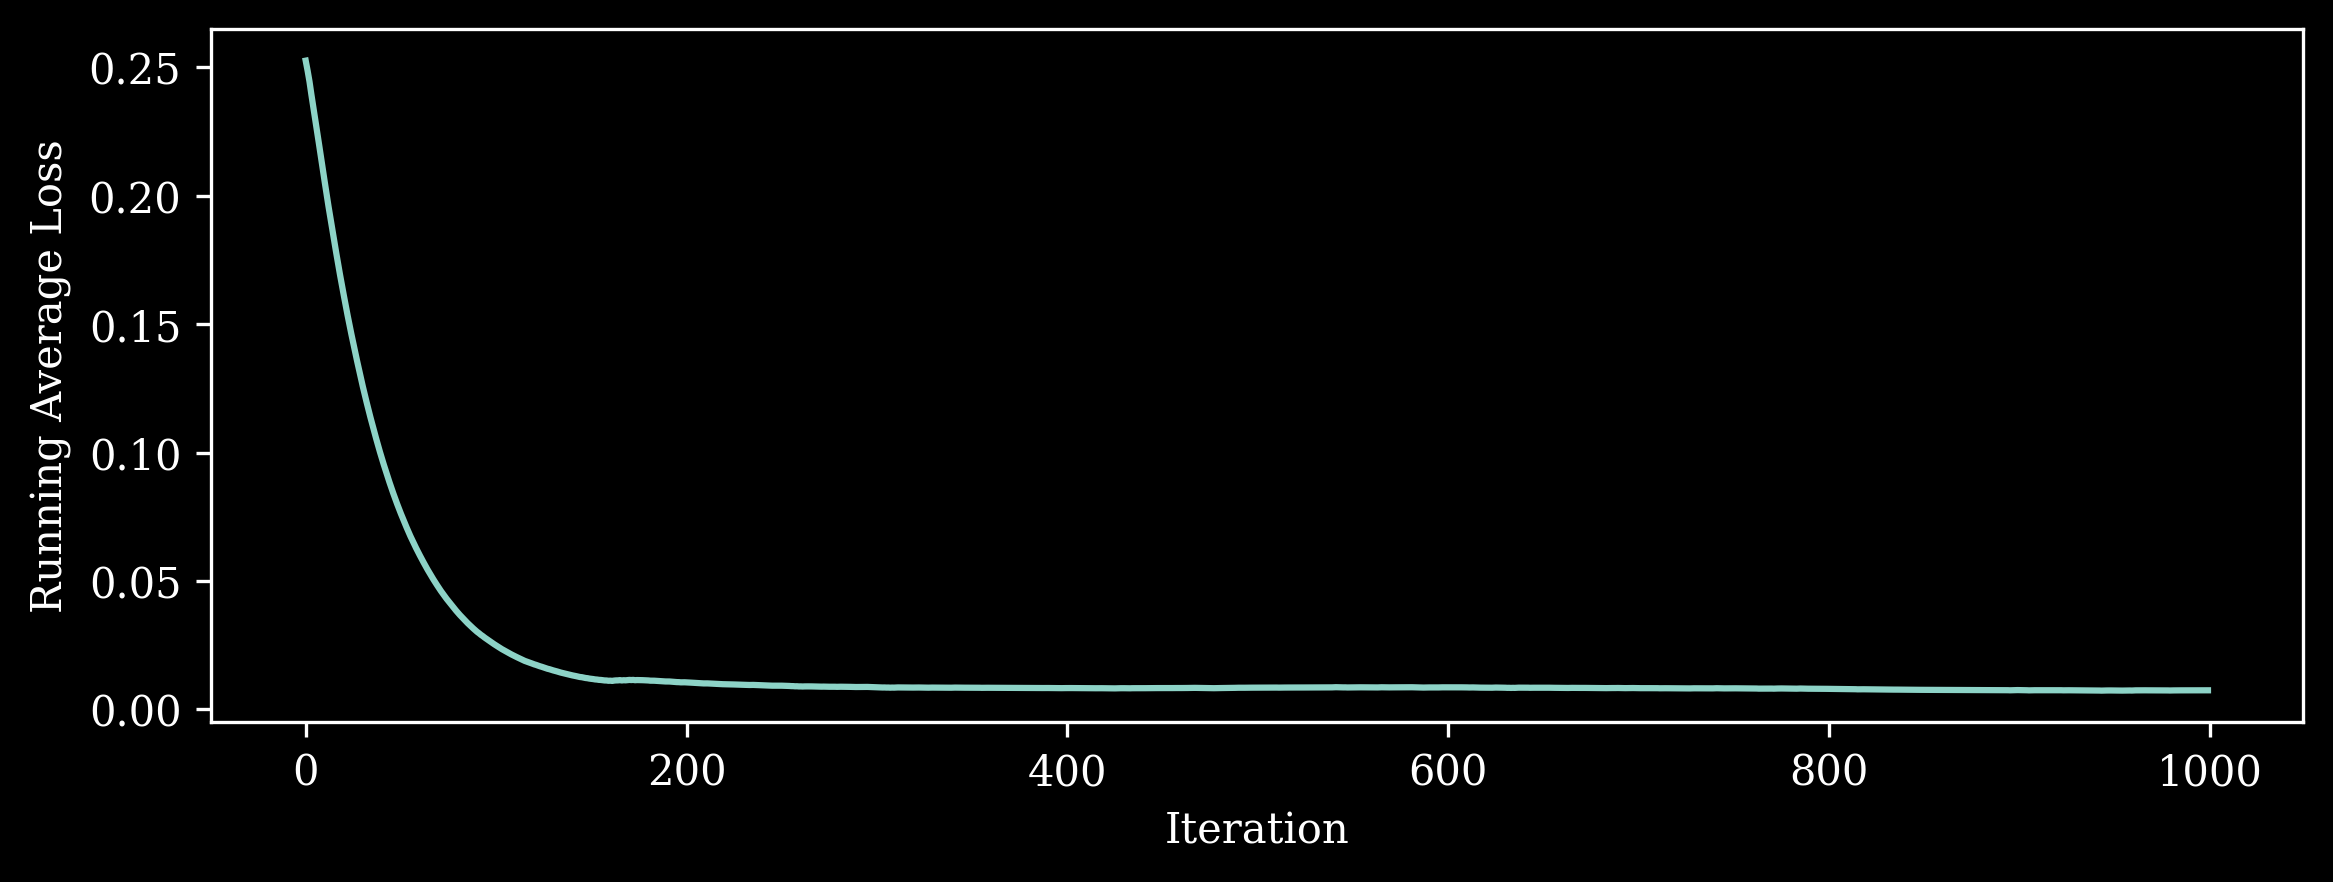

In [48]:
plt.plot(loss_meter.losses) # weighted loss values
plt.xlabel("Iteration")
plt.ylabel("Running Average Loss")

In [49]:
torch.save(my_cnn_model.state_dict(), "dy_dt_CNNy_1000_steps.pt")

In [51]:
y_orig_torch_full[[0]].shape

torch.Size([1, 1, 64, 64])

Text(0.5, 1.0, 'IC')

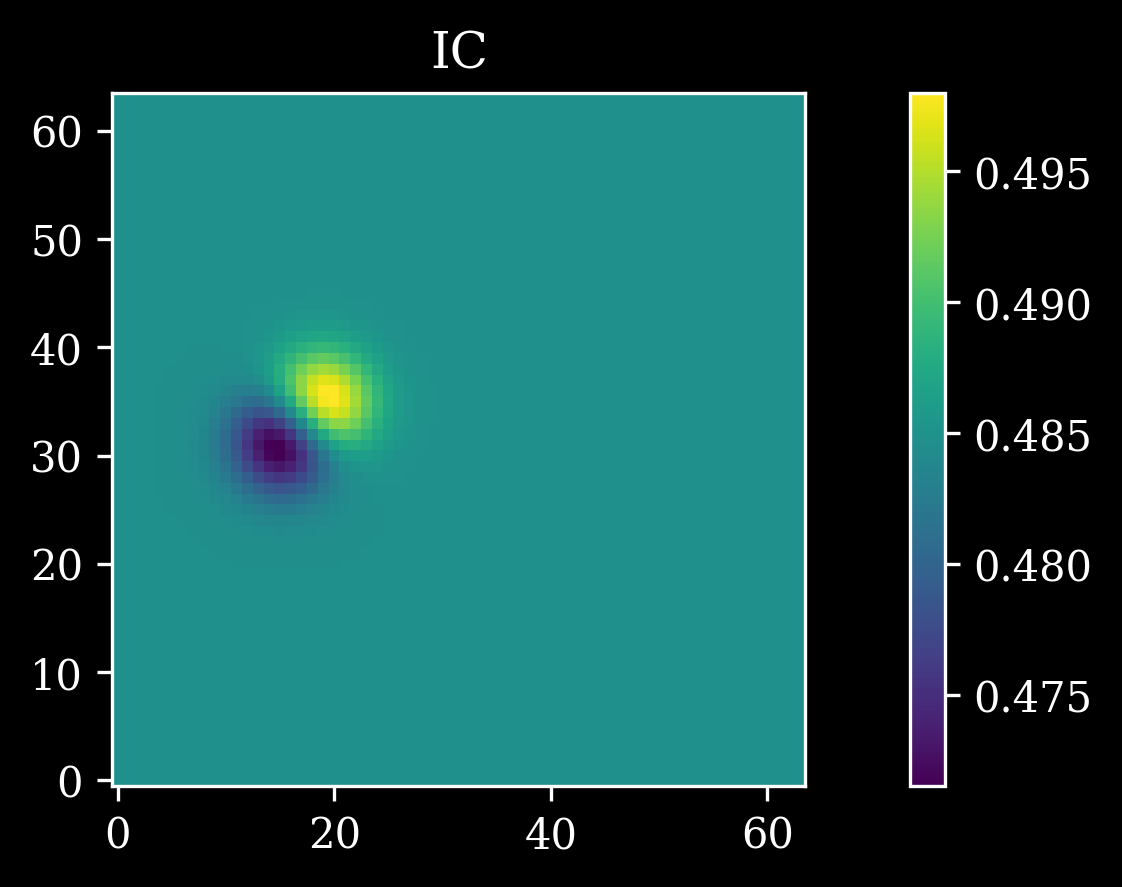

In [53]:
plt.imshow(y_orig_torch_full[[0]][0, 0, :, :].cpu(),
          origin="lower")
plt.colorbar()
plt.title("IC")

In [55]:
with torch.no_grad():
    pred_y_final = my_cnn_model([y_orig_torch_full[[0]], t_train_torch]).cpu().numpy()[:, 0, :, :]

In [56]:
pred_y_final.shape

(615, 64, 64)

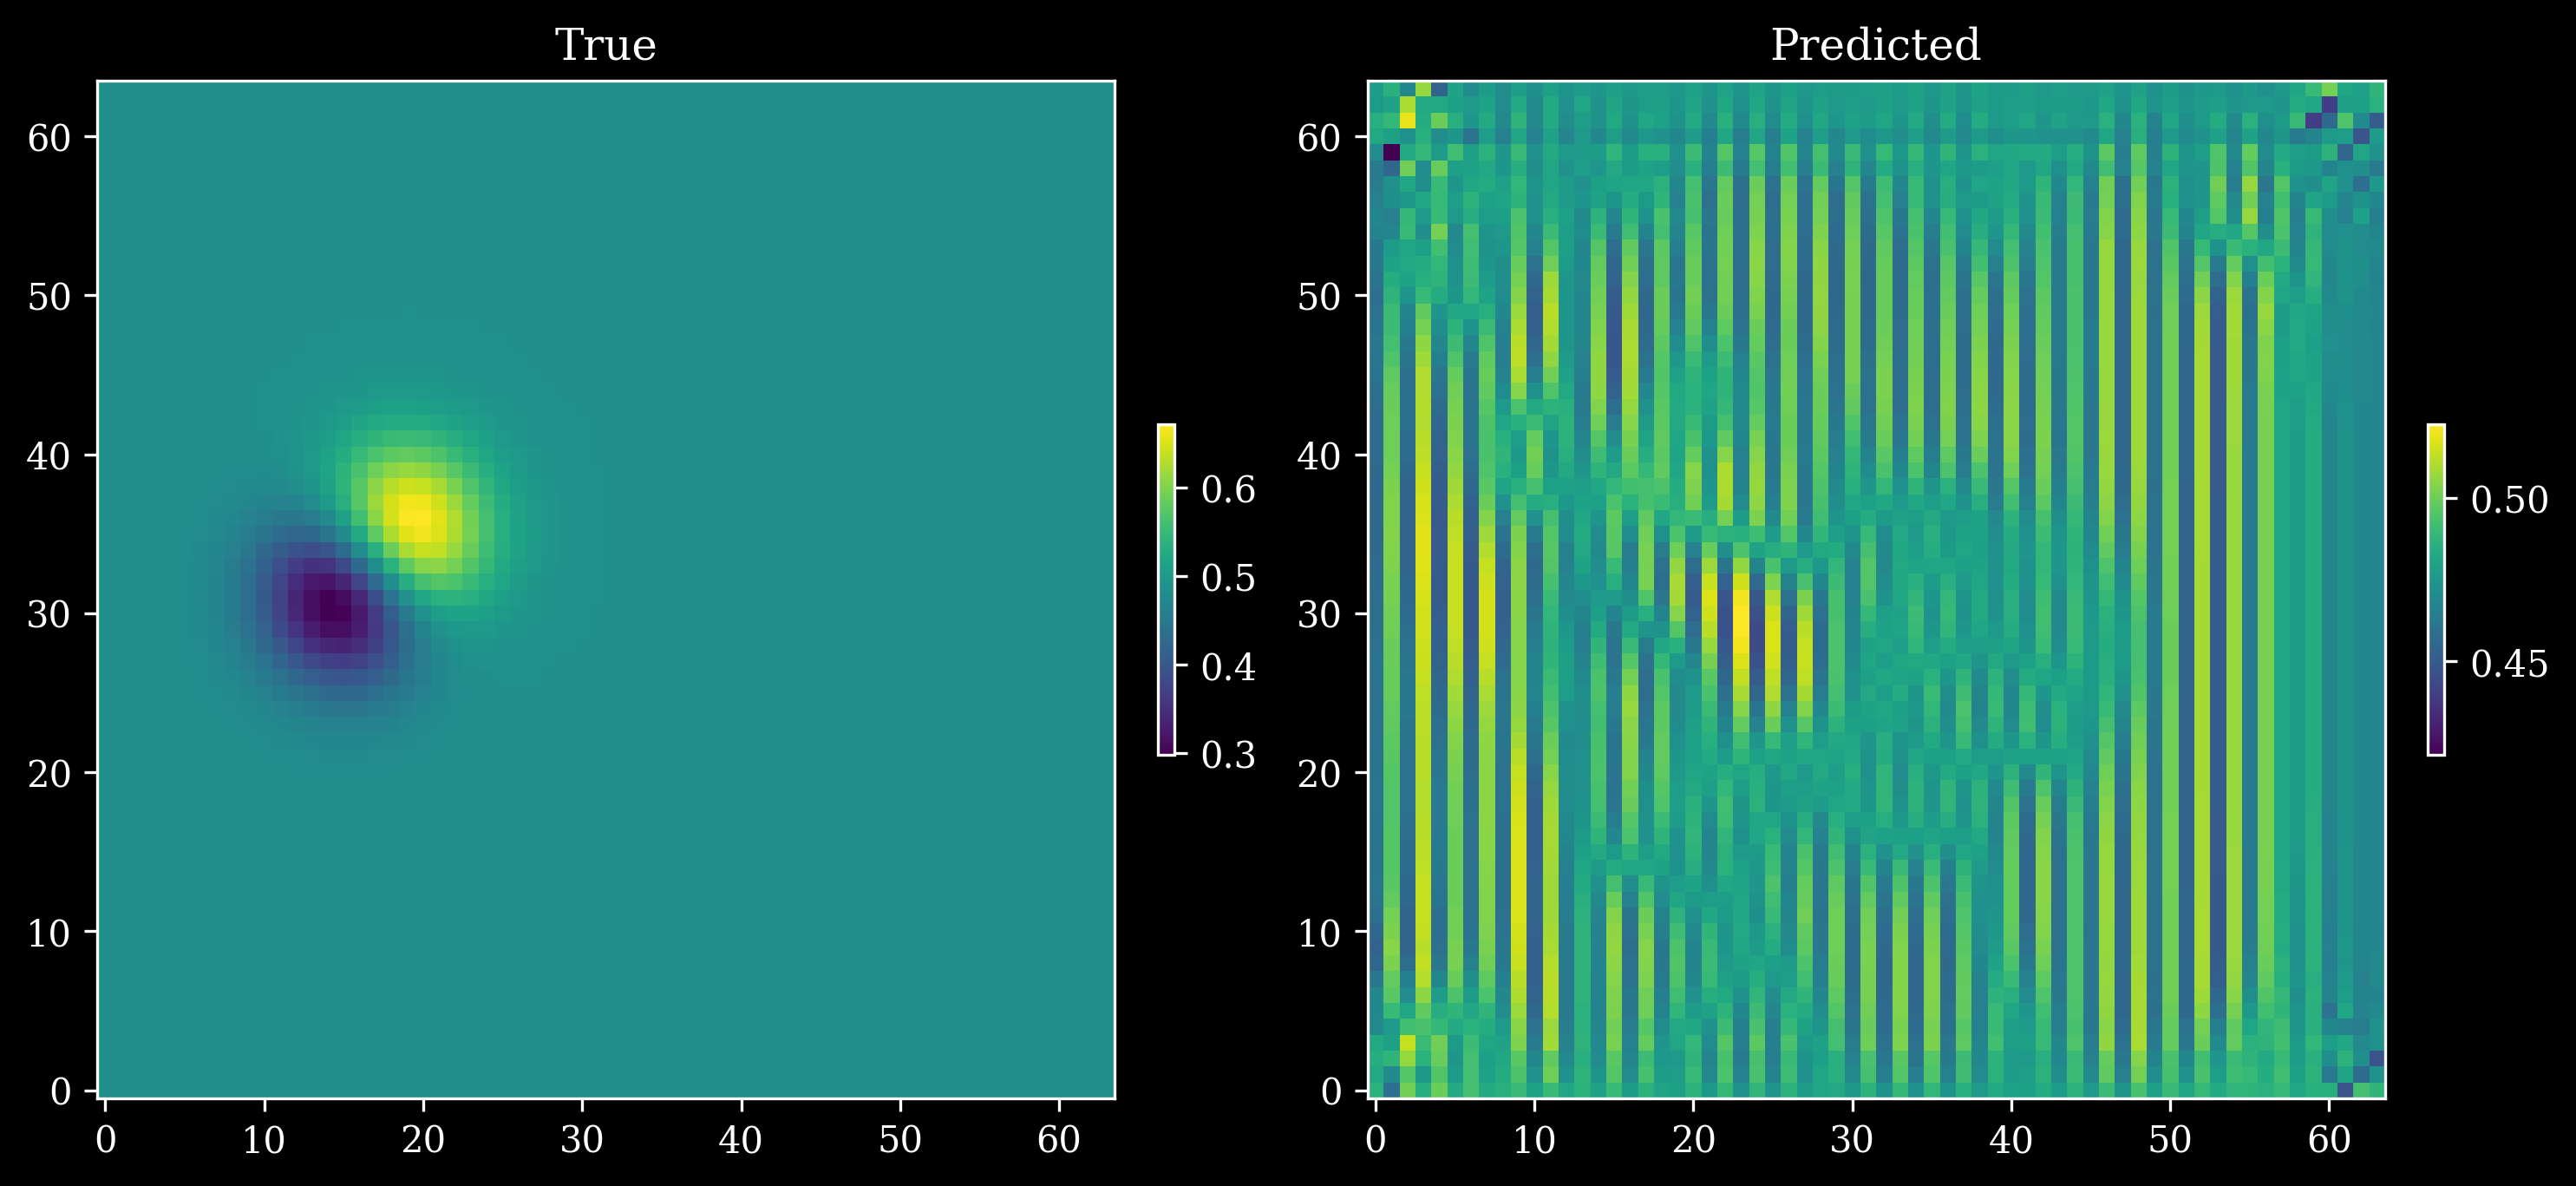

In [57]:
plt_idx = 20
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(y_scaled[plt_idx, :, :],
            origin="lower",
            )
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04, ax=axs[0])

im1 = axs[1].imshow(pred_y_final[plt_idx, :, :],
                   origin="lower",
                   )
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04, ax=axs[1])
fig.tight_layout()

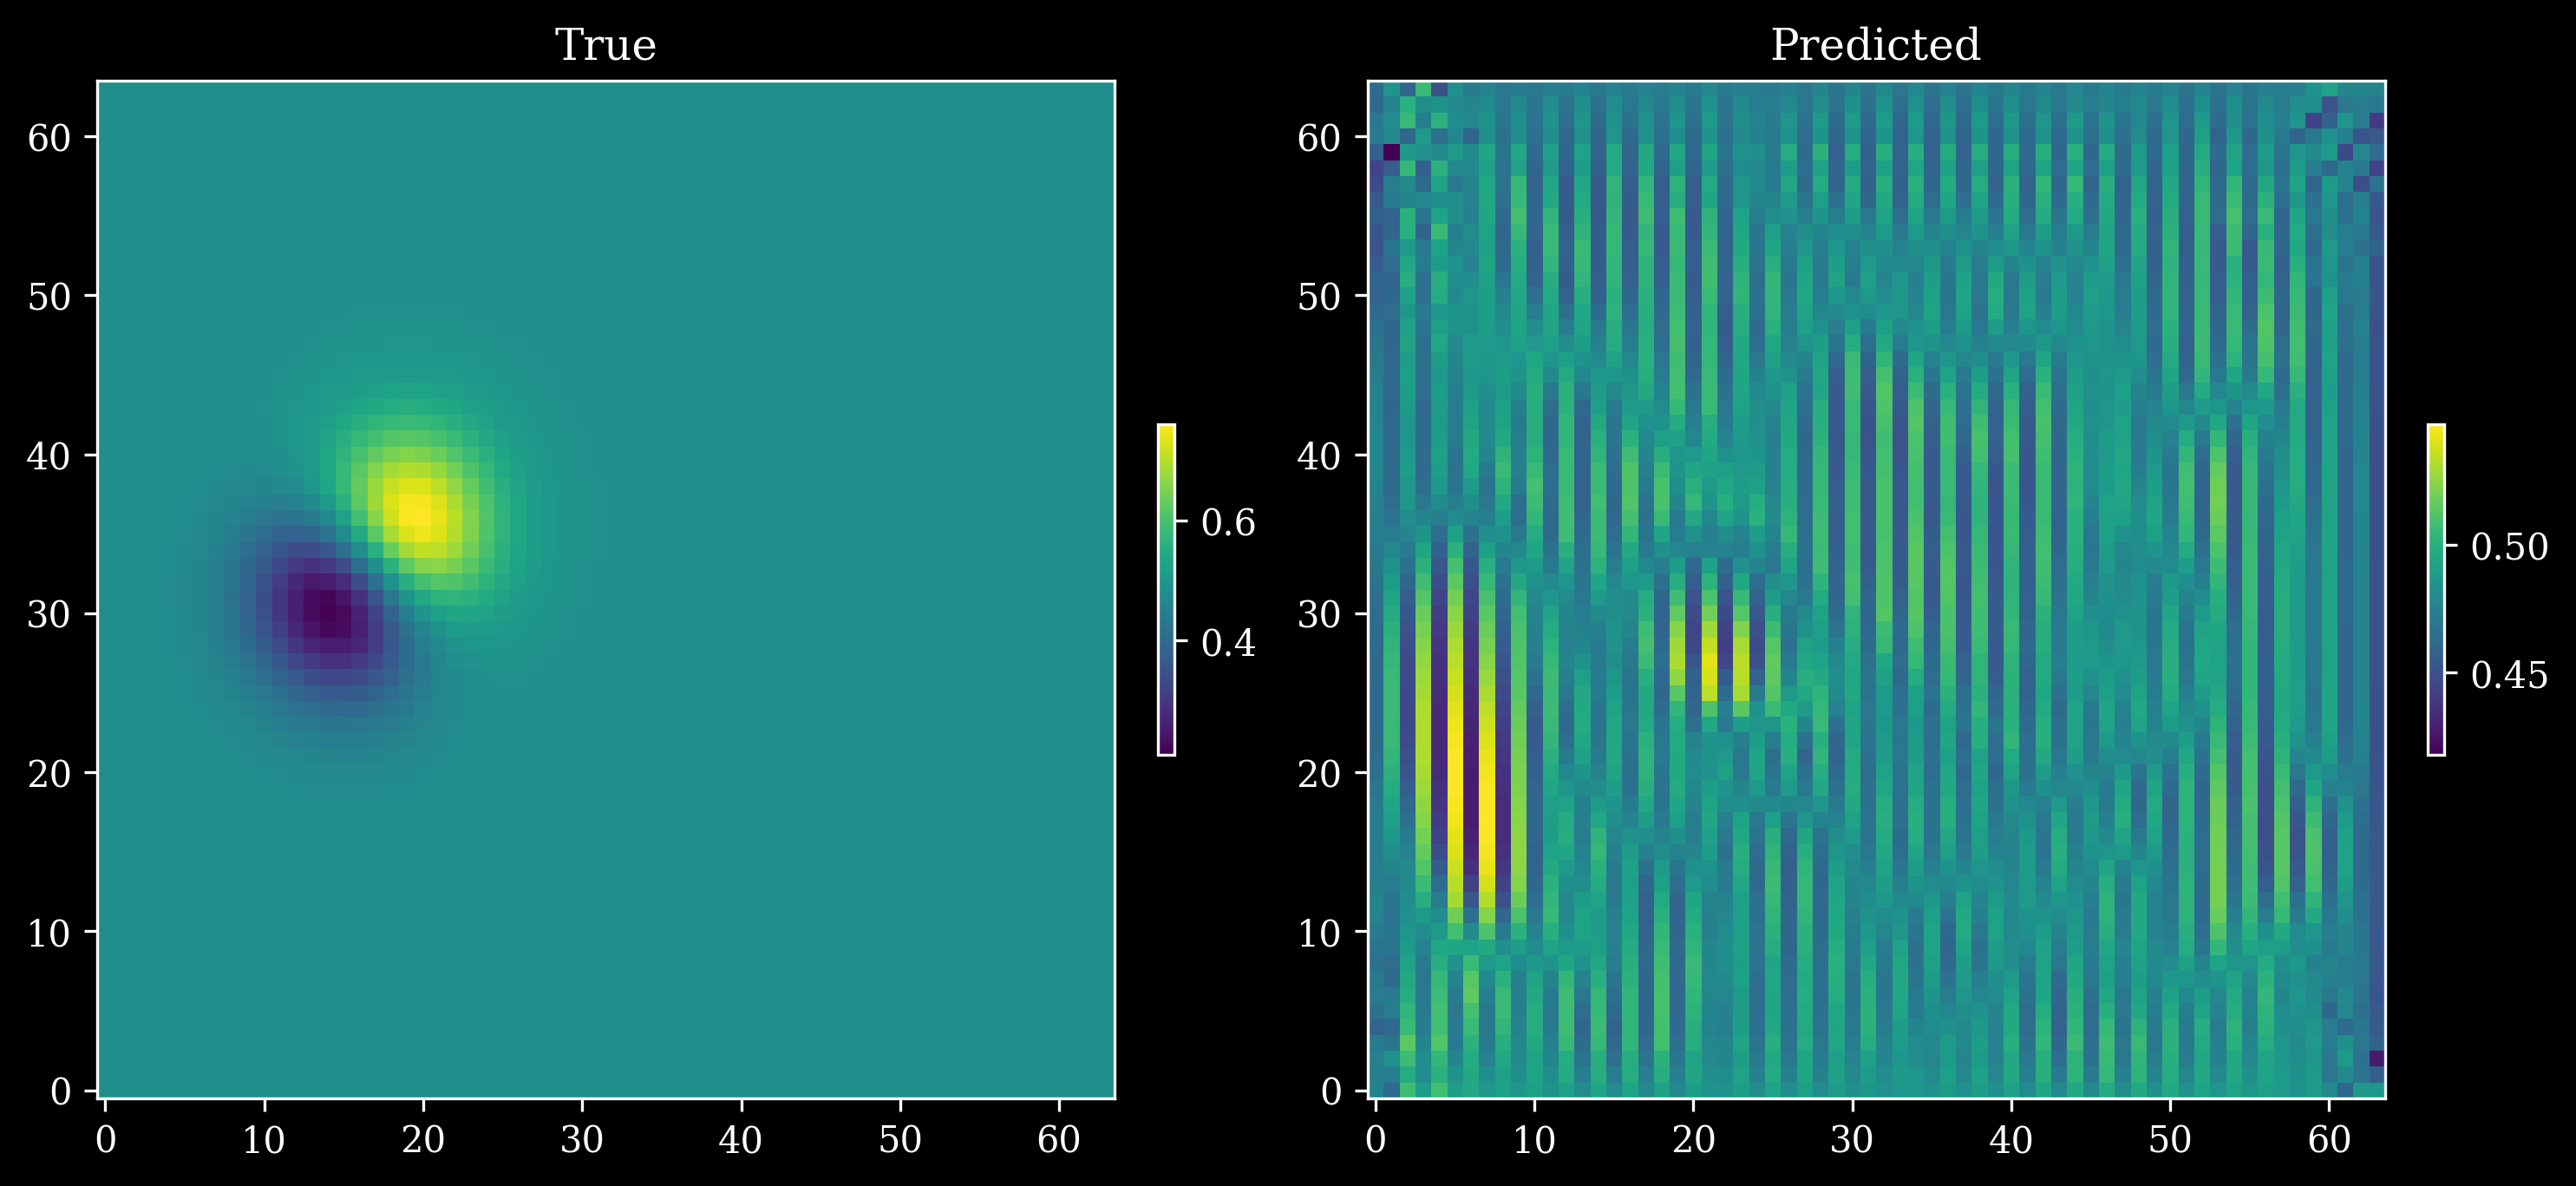

In [58]:
plt_idx = 40
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(y_scaled[plt_idx, :, :],
            origin="lower",
            )
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04, ax=axs[0])

im1 = axs[1].imshow(pred_y_final[plt_idx, :, :],
                   origin="lower",
                   )
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04, ax=axs[1])
fig.tight_layout()

### Operator Inference

In [59]:
import opinf

In [63]:
y_orig_rs = np.transpose(y_scaled, (1, 2, 0))
y_orig_rs.shape

(64, 64, 615)

In [64]:
y_orig_flat_all = y_orig_rs.reshape(-1, 615)

In [66]:
y_orig_flat_all.shape

(4096, 615)

Text(0.5, 1.0, 'IC')

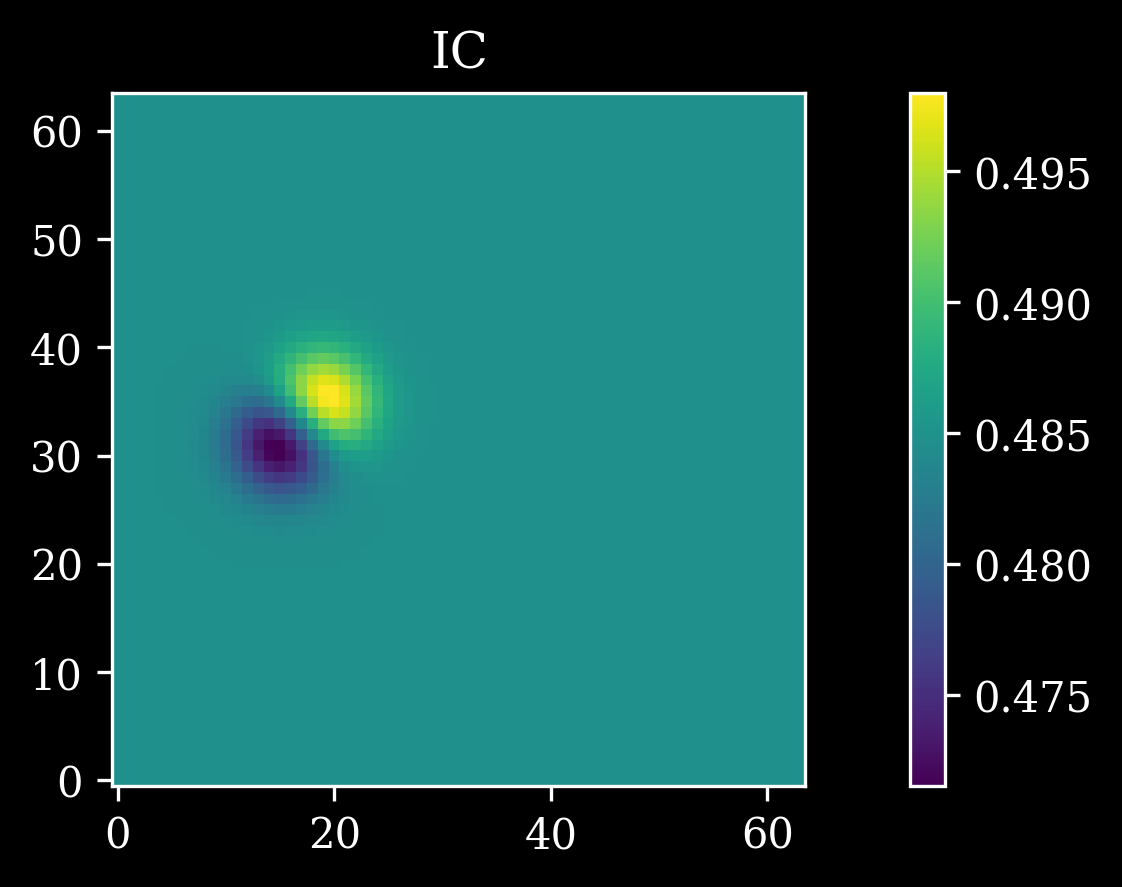

In [65]:
plt.imshow(y_orig_flat_all[:, 0].reshape(64, 64),
          origin="lower")
plt.colorbar()
plt.title("IC")

In [68]:
basis = opinf.pre.PODBasis().fit(y_orig_flat_all, residual_energy=1e-8)

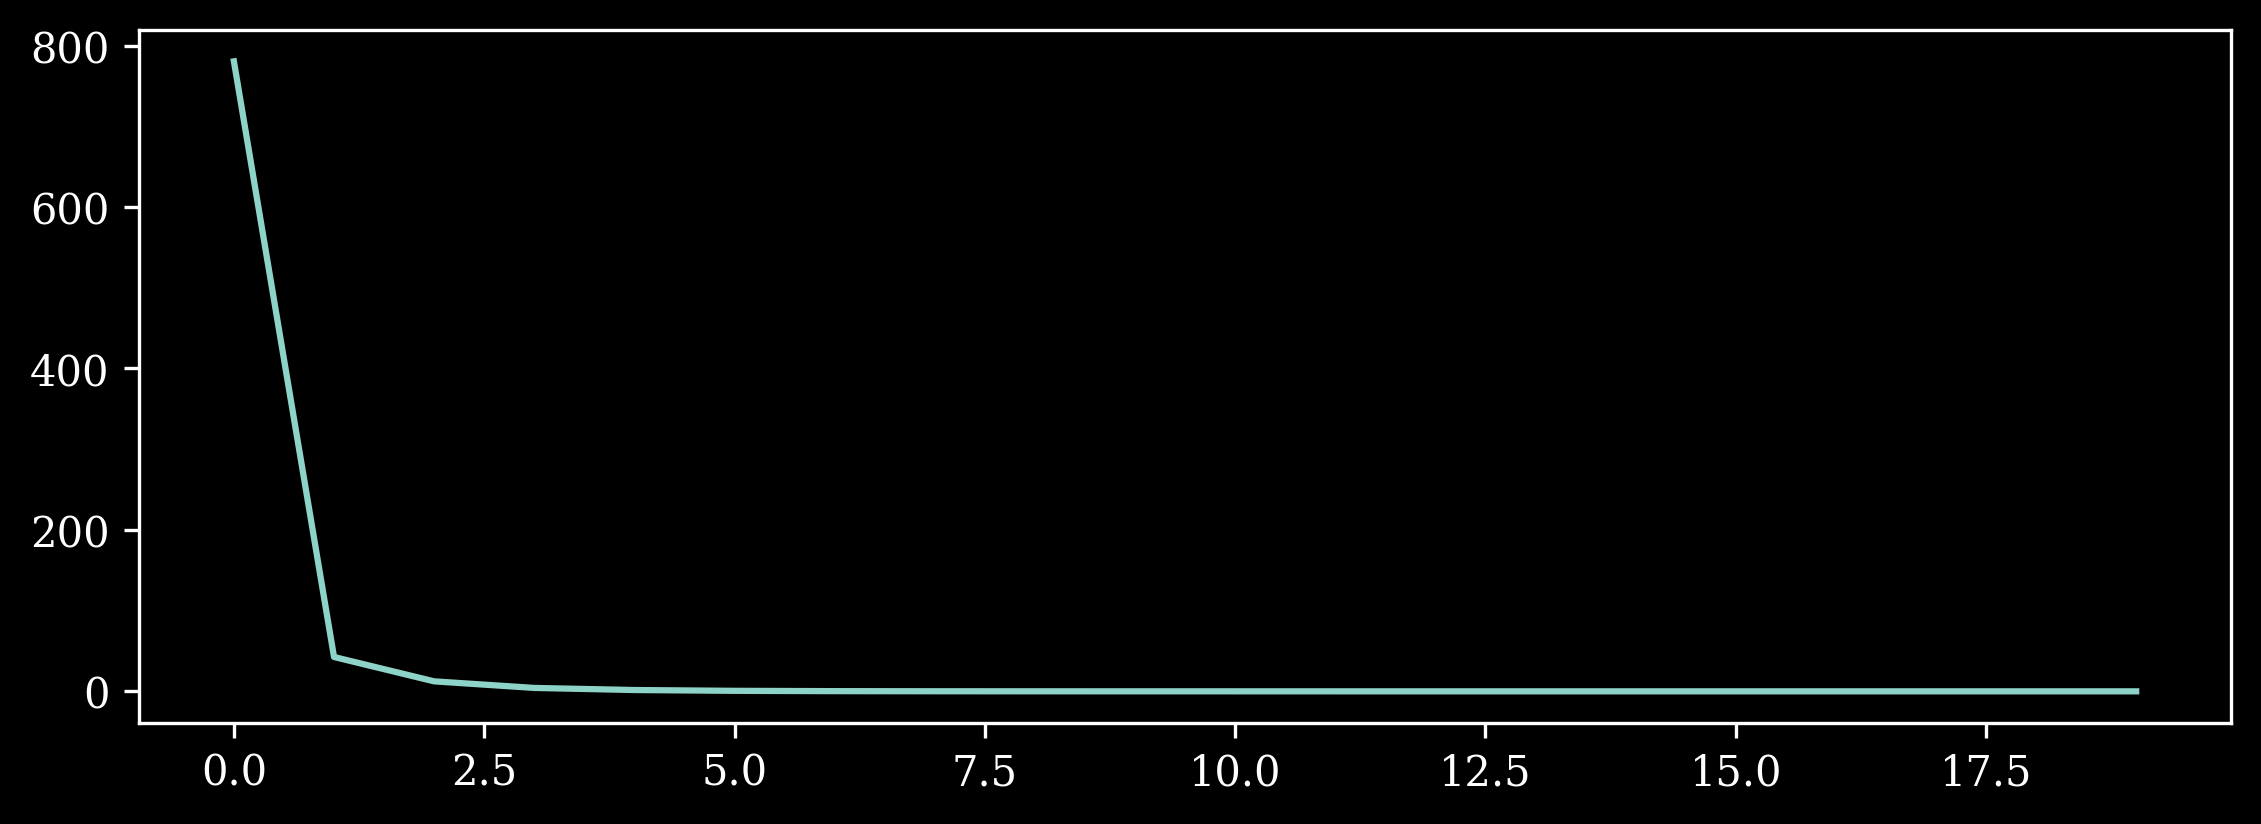

In [70]:
plt.plot(basis.svdvals[:20])

In [73]:
Q_compressed = basis.encode(y_orig_flat_all)

In [74]:
Q_compressed.shape

(8, 615)